# Checkerboard simulation

In [1]:
%cd ..

d:\scarccpy


In [40]:
import os
import pandas as pd
import numpy as np  

from scarcc.preparation.metabolic_model import BasicModel
from scarcc.preparation.find_directory import find_directory 
# get file directory 
model_directory = find_directory('models', os.path.abspath(''))
data_directory = find_directory('Data', os.path.abspath(''))

# initialize model
E0, S0, all_components = BasicModel(model_directory=model_directory, flux_weighting=True).load_ES_models()

## Data Input
Input Lab data to normalized biomass data frames for each drug and each species.

<div class="alert alert-info">
**NOTE :**

Each list for different species under the same gene must have the same length. Elements corresponding to the growth of each bacteria at each drug dosage level.

Example:

Each first element of species 1 and species 2 corresponds to the same dosage (1X concentration)

Each second element of species 1 and species 2 corresponds to another same dosage (2X concentration), ect.
</div>

In [3]:
from scarcc.preparation.perturbation.alpha_finder.checkerboard import read_normalized_growth

model_list = [E0, S0]
normalized_growth_file_path = os.path.join(data_directory, 'normalized_growth_checkerboard.csv')
normalized_growth = read_normalized_growth(normalized_growth_file_path, model_list=model_list)
normalized_growth

D:\scarccpy\src\scarcc\preparation\perturbation\alpha_finder\checkerboard.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  normalized_growth = normalized_growth.applymap(convert_to_list)


,E0,S0
folA,"[1, 1, 0.95, 0.9, 0.5, 0.1]","[1, 0.95, 0.9, 0.7, 0.376, 0.06]"
folP,"[1, 0.95, 0.893, 0.86, 0.62, 0.45]","[1, 0.95, 0.9, 0.76, 0.25, 0]"


Use ``read_normalized_growth`` to read the normalized_growth is required, as it replace columns name with metabolic model instead of the mode id.

<div class="alert alert-info">
**NOTE :**

The metabolic models supplied to ``CheckerboardAlphaFinder`` in the next section is read directly from columns of normalized_growth
</div>

In [4]:
normalized_growth.to_dict(orient='index')

{'folA': {<Model E0 at 0x1646e0ed670>: [1, 1, 0.95, 0.9, 0.5, 0.1],
  <Model S0 at 0x1647fcc0290>: [1, 0.95, 0.9, 0.7, 0.376, 0.06]},
 'folP': {<Model E0 at 0x1646e0ed670>: [1, 0.95, 0.893, 0.86, 0.62, 0.45],
  <Model S0 at 0x1647fcc0290>: [1, 0.95, 0.9, 0.76, 0.25, 0]}}

## Generate and save alpha_table_checkerboard
``maf_kwargs`` are passed to ``MonocultureAlphaFinder``  , see [Deriving Alpha Table from FBA](fba_alpha_derivation.ipynb) for customization



In [5]:
from scarcc.preparation.perturbation.alpha_finder.checkerboard import CheckerboardAlphaFinder

maf_kwargs = {
    'acceptance_threshold_upper': .995,
    'acceptance_threshold_lower': 1.001,
    'precision': 3
}

caf = CheckerboardAlphaFinder(normalized_growth=normalized_growth, data_directory=data_directory, **maf_kwargs)
alpha_table_checkerboard = caf.get_checkerboard_alpha_table()

## Intrinsic resistance of each species

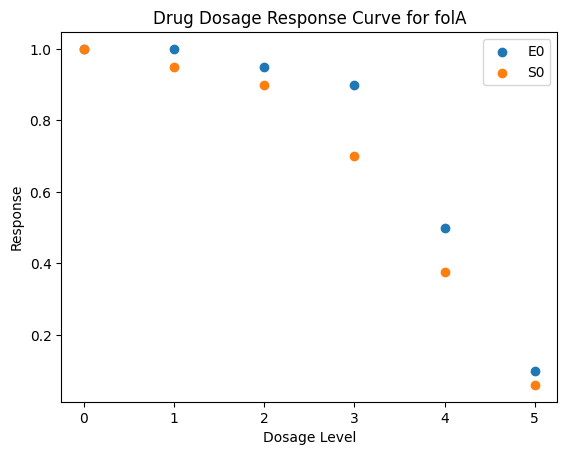

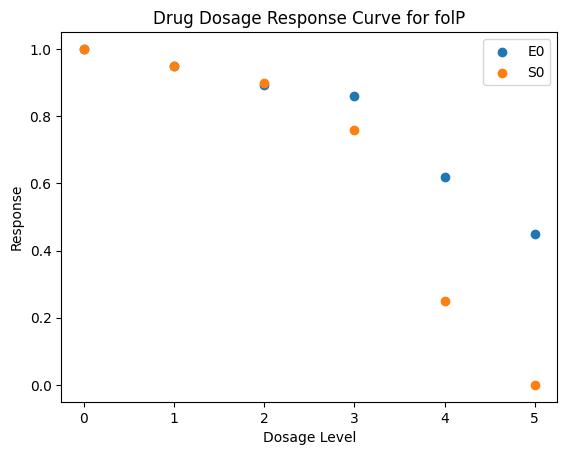

In [6]:
import matplotlib.pyplot as plt
def plot_response(response_record, current_gene):
    plt.figure()

    for Species in caf.species_list:
        df = pd.DataFrame({
            'index': np.arange(len(response_record[current_gene][Species]['nbiomass_x'])),
            'nbiomass_x': response_record[current_gene][Species]['nbiomass_x']
        })
        plt.scatter(x=df['index'], y=df['nbiomass_x'], label=Species.id)
    plt.title(f'Drug Dosage Response Curve for {current_gene}')
    plt.ylabel('Response')
    plt.xlabel('Dosage Level')
    plt.legend()

_ = [plot_response(caf.response_record, current_gene) for current_gene in caf.response_record.keys()]


## Simulation

In [59]:
import cometspy as c

sim_chamber_directory = find_directory('SimChamber', os.path.abspath(''))
alpha_table_path = os.path.join(data_directory, 'alpha_table_checkerboard.csv')
alpha_table_checkerboard = pd.read_csv(alpha_table_path, index_col=0, converters={'lv_pairs': ast.literal_eval})
query_pairs = [(0, 0), (1,0), (0,2), (1,2)] # Uncomment this for full checkerboard
alpha_table_checkerboard = alpha_table_checkerboard.query('lv_pairs in @query_pairs') # Uncomment this for full checkerboard

p = c.params()
p.set_param("defaultKm", 0.00001) # M
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 30)
# p.set_param("maxCycles", 150)
p.set_param("timeStep", 1)
p.set_param('writeFluxLog', True)

checkerboard_simulation_kwargs = {
    'E0': E0,
    'S0': S0,
    'base': sim_chamber_directory,
    'p': p}

In [39]:
from scarcc.sim_engine.checkerboard_workflow import run_checkerboard_workflow

df_container = run_checkerboard_workflow(
    alpha_table = alpha_table_checkerboard, data_directory = data_directory,
    **checkerboard_simulation_kwargs)

biomass, growth_rate, normalized_growth_rate, drug_response_classification, flux data derived from checkerboard were saved in d:\scarccpy\Data\flux_analysis_checkerboard.csv
